Another example of network identification, where both the prior knowledge network and the experimental profiles are provided by the user.

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.2.5


## Parameters for NORDic

See notebook *NORDic Network Identification (NI) Part I.ipynb* for details about the parameters.

In [2]:
file_folder="MODELS/dummy_NI/" 

In [3]:
## We will not need those info, since the prior knowledge network and experiments are available at the start
DisGeNET_credentials = ""
STRING_credentials = ""
LINCS_credentials = ""

seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)
taxon_id=1111
disease_cids=["Unknown"] 
cell_lines=["Cell"]

DISGENET_args = {"credentials": DisGeNET_credentials, "disease_cids": disease_cids}
STRING_args = {"credentials": STRING_credentials, "score": 0}
EDGE_args = {"tau": 0, "filter": True, "connected": True}
accept_nonRNA=True
preserve_network_sign=True
LINCS_args = {"path_to_lincs": "", 
              "credentials": LINCS_credentials,
              "cell_lines": cell_lines, "thres_iscale": None}
SIG_args = {"bin_thres": 0.5}
force_experiments=False
BONESIS_args = {"limit": 1, "exact": True, "max_maxclause": 3}
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

The list of genes to consider will be infered from the network file.

In [4]:
path_to_genes=None

## Dummy network file

See notebook *NORDic Network Identification (NI) Part II.ipynb* for the design of a network file.

In [5]:
from subprocess import call as sbcall
sbcall("mkdir -p "+file_folder, shell=True)

import pandas as pd

PPI = pd.DataFrame([], index=["preferredName_A", "preferredName_B", "sign", "directed", "score"])
PPI[0] = ["a","b",2,0,0.5]
PPI[1] = ["a","c",-1,1,0.5]
PPI[2] = ["b","c",2,1,0.5]
NETWORK_fname = file_folder+"full_PPI.tsv"
PPI.T.to_csv(NETWORK_fname, sep="\t", index=None)

PPI.T

,preferredName_A,preferredName_B,sign,directed,score
0,a,b,2,0,0.5
1,a,c,-1,1,0.5
2,b,c,2,1,0.5


## Dummy experimental file

An experimental file is a data frame where each column correspond to an experimental post-treatment profile, or the untreated cell profile (one per cell line), and rows correspond either to gene names or to "annotation", "perturbed", "perturbation", "cell_line", "sigid":

- "annotation" is equal to "1" if the corresponding profile is a control (untreated cell profile), "2" if it is a post-treatment profile
- "perturbed" is the name of the gene being perturbed in the experiment corresponding to the considered column, or "None" for the control profile
- "perturbation" is the type of gene perturbation ("KD" for knockdown, "OE" for overexpression, or "None" for the control profile)
- "cell_line" is the name of the cell line in which the experiment occurred
- "sigid" is the identifier of the experimental profile (unique to each profile)

In this case, we consider two experimental treated profiles (where gene *a* is over-expressed in our dummy cell line "Cell": "Exp1", and another where gene *b* is knocked-down in cell line "Cell": "Exp2"), and the control ("untreated") profile for cell line "Cell" where no gene perturbation has been applied.

In [6]:
import numpy as np

experiments = pd.DataFrame([], index=["a", "b", "c", "annotation", "perturbed", "perturbation", "cell_line", "sigid"])
experiments["Exp1"] = [1,np.nan,0,2,"a","OE","Cell","P1"]
experiments["Ctrl"] = [0,np.nan,np.nan,1,"None","None","Cell","P2"]
experiments["Exp2"] = [1,np.nan,0,2,"b","KD","Cell","P3"]
EXPERIMENTS_fname = file_folder+"experiments.csv"
experiments.to_csv(EXPERIMENTS_fname, sep=",")

experiments

,Exp1,Ctrl,Exp2
a,1,0,1
b,NaN,NaN,NaN
c,0,NaN,0
annotation,2,1,2
perturbed,a,None,b
perturbation,OE,None,KD
cell_line,Cell,Cell,Cell
sigid,P1,P2,P3


## Parameter finetuning

In [7]:
EDGE_args.update({"tau": 0, "filter": False, "connected": True})
LINCS_args.update({"thres_iscale": 0})
SIG_args.update({"bin_thres": 0.5})
BONESIS_args.update({"limit": 10, "exact": False, "max_maxclause": 2})

## Network identification using existing network and experimental profiles

In [8]:
from NORDic.NORDic_NI.functions import network_identification

solution = NORDic.NORDic_NI.functions.network_identification(
    file_folder, taxon_id, path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
    string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args,
    bonesis_args=BONESIS_args, weights=DESIRABILITY, experiments_fname=EXPERIMENTS_fname,
    seed=seed_number, network_fname=NETWORK_fname, njobs=njobs, force_experiments=force_experiments, 
    accept_nonRNA=accept_nonRNA, preserve_network_sign=preserve_network_sign)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 3 genes imported.
2. Import network from MODELS/dummy_NI/full_PPI.tsv... ... 3 edges in model (including 2 directed edges) with a total of 3 non-isolated genes
3. Import experiments from MODELS/dummy_NI/experiments.csv... 
	1 cell lines are considered (['Cell'])
... 3 genes in 3 profiles (3 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 3 unique edges involving genes both in experiments (3 genes in total)
... score_STRING 0.000000	3 genes (non isolated in PPI)	7 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 1 negative, 3 positive undirected interactions (4 edges in total), 3 non isolated genes in experiments
3. Build dynamical constraints by binarization of experimental profiles...  ...... 2 experiments on 1 cell lines and 3/3 genes (Frobenius norm signature matrix: 2.236, 1 

  0%|                                                         | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.0s
Found 7 solutions in 0.0s (first in 0.0s; rate 0.0s)

100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.62it/s]


--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...7 solutions (7 unique solutions)
... 7 solutions (2/4 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 0 edges
<MODEL VISUALIZATION> Maximal solution: 2 edges
            1         2         3         4         5         6         7
GTP  0.899887  0.843846  0.843846  0.843846  0.843846  0.692201  0.692201


<MODEL SELECTION> Saving optimal model in 'MODELS/dummy_NI//solution.bnet' ...
a <- 1
b <- a
c <- !a

... saved!


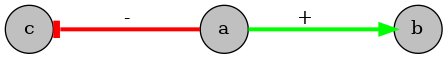

In [9]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 